# Particles

In [46]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy import interpolate
import seaborn as sns

## Constants

In [3]:
PROTON_REST_MASS =  938.27 # MeV/c^2
ELEMENTARY_CHARGE = 1.6021766208e-19 # C

## Energy loss

### Energy unit conversion

In [4]:
def calc_energy_to_beta(energy, rest_mass):
    return np.sqrt(1 - (rest_mass / (rest_mass + energy))**2)

# Scrapped from the web calculator
def calc_energy_to_beta2(E):
    m_amu = 1.660539040e-27
    c_light = 299792458
    e = 1.6021766208e-19
    m_amu_MeV = m_amu*c_light*c_light/e/1e6
    gamma = (E + m_amu_MeV) / m_amu_MeV
    beta = math.pow(1 - 1 / (gamma * gamma), 0.5)
    return beta

### Calculation of mean ionization potential in eV

In [5]:
def calc_mean_ionization_potential_ev(Z):
    """
    Calculate the mean ionization potential of a material using the Ziegler formula.

    Args:
        Z (float): Atomic number of the material.

    Returns:
        float: Mean ionization potential of the material (in eV).
    """
    if Z <= 0:
        raise ValueError("Atomic number must be greater than zero.")

    I = 9.76 * Z+58.8 * Z ** (-0.19)    

    return I

#### Example

In [6]:
calc_mean_ionization_potential_ev(14)

172.25336405711283

### [Web calculator](https://web-docs.gsi.de/~lestinsk/beamcalc/bb.php)

### Scrapped Bethe-Bloch energy loss calculation


In [7]:
def js_bethe_bloch(beta, Zp, Zt, Mt, rho):
    # Constants
    c_light = 299792458             # [m/s]
    epsilon_0 = 8.854187817e-12;	# Coulomb / (V * m)
    me = 9.10938356e-31             # electron mass [kg]
    e = 1.6021766208e-19;		    # Elementary charge [Coulomb]
    m_amu = 1.660539040e-27;		# AMU [kg]
    m_amu_MeV = m_amu*c_light*c_light/e/1e6
    Na = 6.022140857e23     		# Avogadro constant

    # Rescale g/cm^-3 to cm^-3
    rho *= Na / Mt * 1e6

    beta2 = beta**2
    c2 = c_light**2
    n = Zt * rho
    I = 0
    if Zt < 13:
        I = 12 * Zt + 7
    else:
        I = 9.76 * Zt + 58.8 * math.exp(-0.19 * math.log(Zt))
    I *= e
    minusdEdx = 4 * math.pi * n * Zp * Zp / (me * c2 * beta2)
    minusdEdx *= math.pow(e * e / (4 * math.pi * epsilon_0), 2)
    minusdEdx *= (math.log(2 * me * c2 * beta2 / (I * (1 - beta2))) - beta2)
    minusdEdx *= 1 / e / 1000 / 1e6
    return minusdEdx

#### Example

In [8]:
E = 1
Zp = 1
Zt = 73
Mt = 180.94
rho = 16.65

beta = calc_energy_to_beta(E, PROTON_REST_MASS)

js_bethe_bloch(beta, Zp, Zt, Mt, rho)

104.69515069243712

### Scrapped stopping range calculation

In [9]:
def js_stopping_range(Ep, Mp, Zp, Mt, Zt, rho):
    # Constants
    c_light = 299792458;		    # metres / sec
    e = 1.6021766208e-19;		    # Elementary charge [Coulomb]
    m_amu = 1.660539040e-27;		# AMU [kg]
    m_amu_MeV = m_amu*c_light*c_light/e/1e6
    Na = 6.022140857e23     		# Avogadro constant

    # Plot stuff
    plot_x = []
    plot_E = []
    plot_dEdx = []

    # Rescale g/cm^-3 to cm^-3
    rho_scaled = rho * Na / Mt * 1e6

    dx = 1e6 * 1e22 * Ep / rho_scaled / 1000 / Zt / Zp / Zp * Mp
    x = 0
    Eloss = 0
    lEloss = 0
    dElossdx = 0
    ldElossdx = 0
    sr = 0
    Ei = Ep
    while Ei > 0:
        gamma = (Ei + m_amu_MeV) / m_amu_MeV
        beta = math.pow(1 - 1 / (gamma * gamma), 0.5)
        Eloss = js_bethe_bloch(beta, Zp, Zt, Mt, rho) / Mp * dx
        if Eloss < 0:
            break
        
        Ei -= Eloss
        x += dx
        dElossdx = (Eloss - lEloss) / dx

        plot_dEdx.append(Eloss / dx)
        plot_E.append(Ei)
        plot_x.append(x)

        if sr == 0 and Ei <= 0.3 * Ep and dElossdx >= ldElossdx and dElossdx < 0:
            sr = x
        lEloss = Eloss
        ldElossdx = dElossdx
    if sr > 0:
        return sr, plot_x, plot_E, plot_dEdx
    else:
        return x, plot_x, plot_E, plot_dEdx

def plot_stopping_range(x, y, dEdx=None):
    plt.figure(figsize=(7, 5))
    plt.plot(x, y)
    if dEdx is not None:
        plt.plot(x, dEdx)

    plt.title("Stopping Range")
    plt.xlabel("Depth [mm]")
    plt.ylabel("Energy [MeV]")
    plt.grid(True)
    plt.show()

#### Example

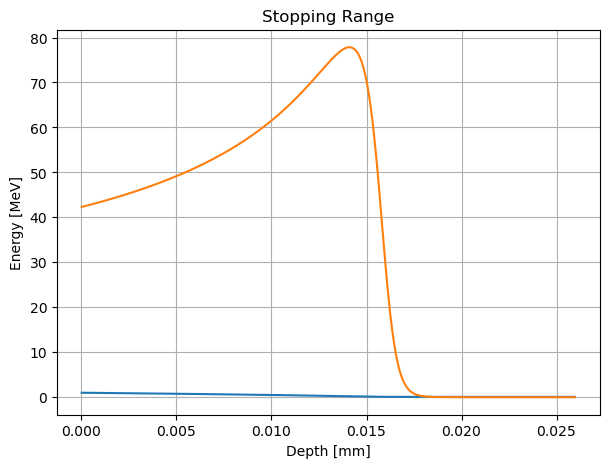

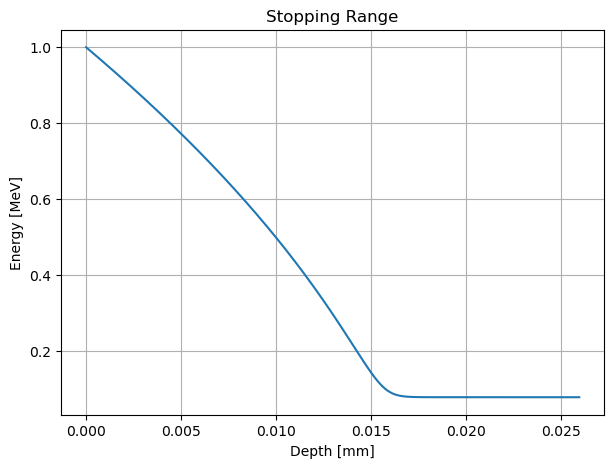

0.01582686561203228

In [10]:
Ep = 1
Mp = 1
Zp = 1

Mt = 28.0855
Zt = 14
rho = 2.33

beta = calc_energy_to_beta2(Ep)
bb = js_bethe_bloch(beta, Zp, Zt, Mt, rho)

sr, x, y, yy = js_stopping_range(Ep, Mp, Zp, Mt, Zt, rho)

plot_stopping_range(x, y, yy)
plot_stopping_range(x, y)
sr

# Zasięg protonów w modelu detektora

In [11]:
MATERIALS = {
    # Element: (Atomic mass, Atomic number, Density in g/cm^3)
    "Si": (28.0855, 14, 2.33),
    "Ta": (180.94788, 73, 16.65),
    "Al": (26.9815385, 13, 2.7),
    "Cu": (63.546, 29, 8.96),
    **{f"D{i}":(28.0855, 14, 2.33) for i in range(1, 9)}
}

In [12]:
def plot_proton_stopping_range2(energy, atomic_mass, atomic_numer, density):
    sr, x, y, yy = js_stopping_range(energy, 1, 1, atomic_mass, atomic_numer, density)
    plot_stopping_range(x, y, yy)
    plot_stopping_range(x, y)
    return sr

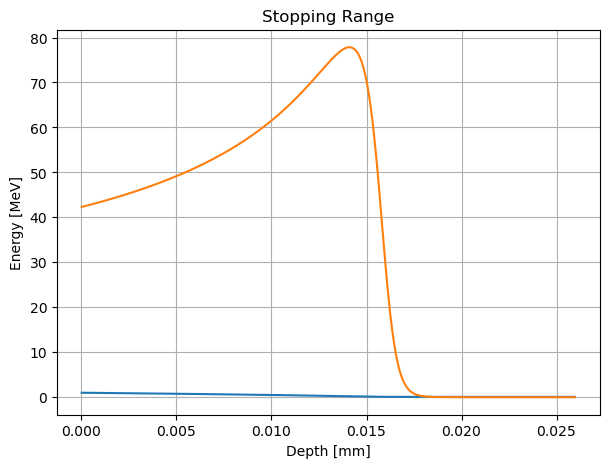

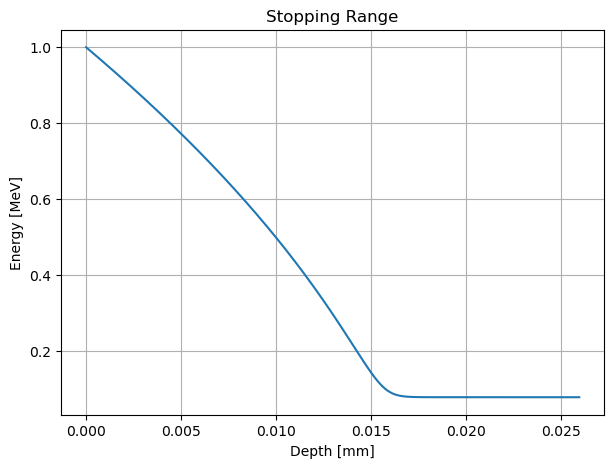

0.01582686561203228

In [13]:
plot_proton_stopping_range2(1, *MATERIALS["Si"])

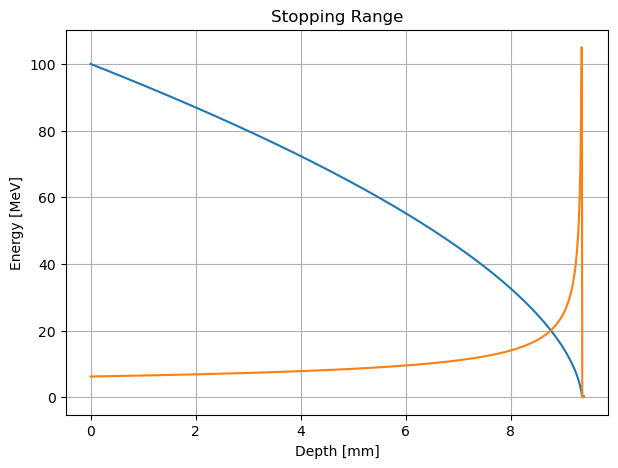

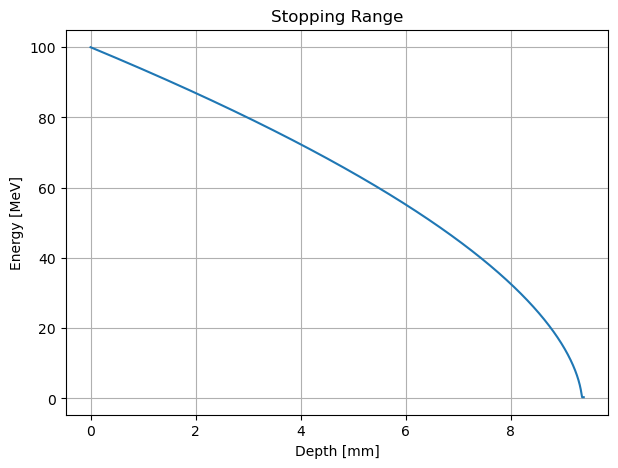

9.35738122673617

In [14]:
plot_proton_stopping_range2(100, *MATERIALS["Ta"])

In [15]:
PSD_LAYERS = (
    # (Material, Thickness in mm)
    ("Al", 0.2),

    ("D1", 0.3),
    ("D2", 0.3),
    ("Al", 0.4),
    ("D3", 0.3),
    ("Al", 1.2),
    ("D4", 0.3),
    ("Al", 3.3),

    ("D5", 0.3),
    ("Ta", 2.0),
    ("D6", 0.3),
    ("Ta", 4.8),
    ("D7", 0.3),
    ("Ta", 10.8),
    ("D8", 0.3),
)

In [16]:
def linear_interpolation(x_points, y_points, x_point):
    """
    Perform linear interpolation for a given x value based on lists of x and y points.

    :param x_points: List of x-coordinates.
    :param y_points: List of y-coordinates corresponding to x-coordinates.
    :param x_point: The x value for which to interpolate the y value.
    :return: Interpolated y value for the given x_point.
    """
    # Check if the lists are of the same length
    if len(x_points) != len(y_points):
        raise ValueError("The lists x_points and y_points must have the same length.")

    # Find the interval x_point is in
    for i in range(len(x_points) - 1):
        if x_points[i] <= x_point <= x_points[i + 1]:
            # Perform linear interpolation
            return y_points[i] + (y_points[i + 1] - y_points[i]) * (x_point - x_points[i]) / (x_points[i + 1] - x_points[i])

    # If x_point is outside the range of x_points
    raise ValueError("x_point is outside the range of x_points.")

<img src="../docs/ranges.jpg" width=80>

In [17]:
PSD_RANGES = {
    "D1": (5, 8.2),
    "D2": (8.2, 13),
    "D3": (13, 22),
    "D4": (22, 35),
    "D5": (35, 58),
    "D6": (58, 94),
    "D7": (94, 153),
    "D8": (153, 250),
}

def simulate(init_energy, verbose=True):
    energy = init_energy
    last_detector = "00"
    for material, thickness in PSD_LAYERS:
        if verbose: print("\nPENETRATING LAYER OF", material, "WITH THICKNESS", thickness, "mm")
        if verbose: print("Energy before:", energy, "MeV")

        atomic_mass, atomic_number, density = MATERIALS[material]

        stopping_range, data_x, data_e, data_dEdx = js_stopping_range(energy, 1, 1, atomic_mass, atomic_number, density)

        if material.startswith("D"):
            last_detector = material

        if not data_x:
            if verbose: print(f"Electron cannot penetrate {material} layer. Stopping range: {stopping_range} mm, Thickness: {thickness} mm")
            break

        if thickness > data_x[-1]:
            if verbose: print(f"Electron cannot penetrate {material} layer. Stopping range: {stopping_range} mm, Thickness: {thickness} mm")
            break

        if linear_interpolation(data_x, data_dEdx, thickness) < 1e-10:
            if verbose: print(f"Electron cannot lose enough energy in {material} layer.")
            break

        new_energy = linear_interpolation(data_x, data_e, thickness)
        energy = new_energy

        if verbose: print("Energy after:", energy, "MeV")
        if verbose: print("Stopping range:", stopping_range, "mm")
    else:
        if verbose: print("Electron penetrated the detector.")
        last_detector = "PENETRATED9"
    return last_detector


# simulate(250, verbose=True)

In [18]:
def ranges_bin_ary_search(da, db, fn, eps=0.1):
    left, right = 1, 160
    center = (left + right) / 2
    fn_center = fn(center)

    while not (fn_center == da and fn(center + eps) == db):
        if fn_center > da:
            right = center
        elif fn_center <= da:
            left = center
        
        center = (left + right) / 2
        fn_center = fn(center)
    
    return center, center + eps

def find_range(d, fn, eps=0.1):
    a, _ = ranges_bin_ary_search(d - 1, d, fn, eps)
    _, d = ranges_bin_ary_search(d, d + 1, fn, eps)
    return a + eps, d - eps


# fn = lambda e: int(simulate(e, verbose=False)[-1])
# for d in range(1, 8):
#     print(f"D{8} =", find_range(8, fn))


In [19]:
# Ranges of the simulated detector
PSD_SIMULATED_RANGES = {
    "D1": (5.137109375, 8.37548828125),
    "D2": (8.47548828125, 14.04296875),
    "D3": (14.14296875, 22.427734375),
    "D4": (22.527734375, 36.47998046875),
    "D5": (36.57998046875, 57.3642578125),
    "D6": (57.4642578125, 94.0087890625),
    "D7": (94.1087890625, 152.546875),
    "D8": (152.646875, 153.09033203125),
}

In [20]:
error = 0
for real, sim in zip(PSD_RANGES.values(), PSD_SIMULATED_RANGES.values()):
    error0 = abs(real[0] - sim[0]) + abs(real[1] - sim[1])
    print(error0)
    error += error0
print(error)

0.31259765625000036
1.3184570312500004
1.5707031249999996
2.0077148437500014
2.2157226562500014
0.5445312499999986
0.5619140624999943
97.26279296875
105.79443359375


# Napięcia wyjściowe

<img src="../docs/asic.jpg" width=800>

In [21]:
def simulate_with_enery_losses(init_energy, verbose=True):
    layers = {detector:0 for detector in PSD_RANGES.keys()}
    
    energy = init_energy

    for material, thickness in PSD_LAYERS:
        if verbose: print("\nPENETRATING LAYER OF", material, "WITH THICKNESS", thickness, "mm")

        atomic_mass, atomic_number, density = MATERIALS[material]

        stopping_range, data_x, data_e, data_dEdx = js_stopping_range(energy, 1, 1, atomic_mass, atomic_number, density)

        if not data_x:
            if material.startswith("D"):
                layers[material] =  energy
            if verbose: print(f"Electron cannot penetrate {material} layer. Stopping range: {stopping_range} mm, Thickness: {thickness} mm")
            break

        if thickness > data_x[-1]:
            if material.startswith("D"):
                layers[material] =  energy
            if verbose: print(f"Electron cannot penetrate {material} layer. Stopping range: {stopping_range} mm, Thickness: {thickness} mm")
            break

        if linear_interpolation(data_x, data_dEdx, thickness) < 1e-10:
            if verbose: print(f"Electron cannot lose enough energy in {material} layer.")
            break

        new_energy = linear_interpolation(data_x, data_e, thickness)
        energy_diff = energy - new_energy
        energy = new_energy

        if material.startswith("D"):
            layers[material] = energy_diff

        if verbose: print("Energy after:", energy, "MeV")
        if verbose: print("Energy diff:", energy_diff, "MeV")
    else:
        if verbose: print("Electron penetrated the detector.")

    return layers


In [22]:
layers = simulate_with_enery_losses(100, verbose=False)
layers

{'D1': 0.40850202007487724,
 'D2': 0.40973359707585644,
 'D3': 0.4128778853004178,
 'D4': 0.42011460713709425,
 'D5': 0.4397923824452761,
 'D6': 0.5025089123913915,
 'D7': 1.1823319629911424,
 'D8': 0}

The number of generated pairs is proportional to the
energy deposited by the incident particle and equals approximately the
energy deposition divided by average ionization energy which for silicon
equals 3.62 eV [65] [66].

In [23]:
ELECTRON_HOLE_PAIR_ENERGY_EV = 3.62 # eV
ELECTRON_HOLE_PAIR_ENERGY_MEV = ELECTRON_HOLE_PAIR_ENERGY_EV / 1e6 # MeV

In [24]:
def diode_energy_to_charge(E):
    Q = E / ELECTRON_HOLE_PAIR_ENERGY_MEV * ELEMENTARY_CHARGE
    return Q

In [25]:
layer_charges = {m:diode_energy_to_charge(e) for m,e in layers.items()}
layer_charges

{'D1': 1.8079900168882337e-14,
 'D2': 1.8134408563293493e-14,
 'D3': 1.827357168711805e-14,
 'D4': 1.8593861922973184e-14,
 'D5': 1.9464781026512533e-14,
 'D6': 2.2240553347434335e-14,
 'D7': 5.232885715825909e-14,
 'D8': 0.0}

# Coincidence logic

<img src="../docs/dac_psd.jpg" width=500>

<img src="../docs/logic_psd.png" width=500>

In [26]:
PSD_THRESHOLDS = {
    # channel,  LT [MeV], HT [MeV]
    "D1": (0.90972, 2.02692),
    "D2": (0.60648, 0.98724),
    "D3": (0.40356, 0.98724),
    "D4": (0.30324, 0.98724),
    "D5": (0.30324, 0.70680),
    "D6": (0.30324, 0.70680),
    "D7": (0.30324, 0.50616),
    "D8": (0.30324, 0.50616),
}

In [27]:
PSD_LOGIC = {
    1: {
        "D1": (None, True),
        "D2": (False, None),
        "D3": (None, None),
        "D4": (None, None),
        "D5": (None, None),
        "D6": (None, None),
        "D7": (None, None),
        "D8": (None, None),
    },
    2: {
        "D1": (True, None),
        "D2": (None, True),
        "D3": (False, None),
        "D4": (None, None),
        "D5": (None, None),
        "D6": (None, None),
        "D7": (None, None),
        "D8": (None, None),
    },
    3: {
        "D1": (True,None),
        "D2": (None,True),
        "D3": (None,True),
        "D4": (False,None),
        "D5": (None,None),
        "D6": (None,None),
        "D7": (None,None),
        "D8": (None,None),
    },
    4: {
        "D1": (True,None),
        "D2": (None,True),
        "D3": (None,True),
        "D4": (None,True),
        "D5": (False,None),
        "D6": (None,None),
        "D7": (None,None),
        "D8": (None,None),
    },
    5: {
        "D1": (None,None),
        "D2": (True,None),
        "D3": (True,None),
        "D4": (True,None),
        "D5": (True,None),
        "D6": (False,None),
        "D7": (None,None),
        "D8": (None,None),
    },
    6: {
        "D1": (None,None),
        "D2": (None,None),
        "D3": (True,None),
        "D4": (True,None),
        "D5": (True,None),
        "D6": (True,None),
        "D7": (False,None),
        "D8": (None,None),
    },
    7: {
        "D1": (None,None),
        "D2": (None,None),
        "D3": (True,None),
        "D4": (True,None),
        "D5": (True,None),
        "D6": (True,None),
        "D7": (True,None),
        "D8": (False,None),
    },
    8: {
        "D1": (None,None),
        "D2": (None,None),
        "D3": (True,None),
        "D4": (True,None),
        "D5": (True,None),
        "D6": (True,None),
        "D7": (True,None),
        "D8": (True,None),
    },
}

In [28]:
def apply_coincidence_logic(values, thresholds, logic):
    bins = {}

    for bin_ in logic.keys():
        is_in_bin = True
        
        for detector in logic[bin_].keys():
            lt = values[detector] > thresholds[detector][0]
            ht = values[detector] < thresholds[detector][1]

            if logic[bin_][detector][0] is not None:
                is_in_bin &= (lt if logic[bin_][detector][0] else not lt)
            
            if logic[bin_][detector][1] is not None:
                is_in_bin &= (ht if logic[bin_][detector][1] else not ht)
            
            if not is_in_bin:
                break

        if is_in_bin:
            bins[bin_] = 1
    
    return bins


In [29]:
channels = simulate_with_enery_losses(180, verbose=False)
channels

{'D1': 0.2710786574040185,
 'D2': 0.2713451460150509,
 'D3': 0.27201709655554396,
 'D4': 0.27351976219475205,
 'D5': 0.27731619887765646,
 'D6': 0.28729965393623047,
 'D7': 0.317680923779875,
 'D8': 0.4882366203093511}

In [30]:
bins = apply_coincidence_logic(channels, PSD_THRESHOLDS, PSD_LOGIC)
bins

{1: 1}

In [31]:
for energy in list(range(1, 101, 4)) + [100, 120, 140, 150, 160, 200]:
    channels = simulate_with_enery_losses(energy, verbose=False)
    bins = apply_coincidence_logic(channels, PSD_THRESHOLDS, PSD_LOGIC)
    print(energy, bins, sep="\t")

1	{1: 1}
5	{1: 1}
9	{}
13	{}
17	{}
21	{}
25	{}
29	{}
33	{}
37	{5: 1}
41	{5: 1}
45	{5: 1}
49	{5: 1}
53	{5: 1}
57	{5: 1}
61	{1: 1, 6: 1}
65	{1: 1, 6: 1}
69	{1: 1, 6: 1}
73	{1: 1, 6: 1}
77	{1: 1, 6: 1}
81	{1: 1, 6: 1}
85	{1: 1, 6: 1}
89	{1: 1, 6: 1}
93	{1: 1, 6: 1}
97	{1: 1, 7: 1}
100	{1: 1, 7: 1}
120	{1: 1}
140	{1: 1}
150	{1: 1}
160	{1: 1}
200	{1: 1}


In [32]:
PSD_RANGES

{'D1': (5, 8.2),
 'D2': (8.2, 13),
 'D3': (13, 22),
 'D4': (22, 35),
 'D5': (35, 58),
 'D6': (58, 94),
 'D7': (94, 153),
 'D8': (153, 250)}

In [33]:
channels = simulate_with_enery_losses(16, verbose=False)
channels = {m:e*0.477 for m,e in channels.items()}
bins = apply_coincidence_logic(channels, PSD_THRESHOLDS, PSD_LOGIC)

channels, bins

({'D1': 0.9103275646960022,
  'D2': 1.032957502769851,
  'D3': 2.436964846527522,
  'D4': 0.0,
  'D5': 0.0,
  'D6': 0.0,
  'D7': 0.0,
  'D8': 0.0},
 {})

In [34]:
for energy in list(range(1, 65, 4)):
    channels = simulate_with_enery_losses(energy, verbose=False)
    channels = {m:e*0.5 for m,e in channels.items()}
    bins = apply_coincidence_logic(channels, PSD_THRESHOLDS, PSD_LOGIC)
    print(energy, bins, sep="\t")

1	{1: 1}
5	{1: 1}
9	{}
13	{}


17	{}
21	{}
25	{}
29	{1: 1}
33	{1: 1}
37	{1: 1}
41	{1: 1}
45	{1: 1}
49	{1: 1}
53	{1: 1}
57	{1: 1}
61	{1: 1}


# Napięcia wejściowe again

In [68]:
out = []
for e in range(0, 200, 5):
    channels = simulate_with_enery_losses(e, verbose=False)
    charges = {m:diode_energy_to_charge(e) for m,e in channels.items()}
    out.append([e, list(charges.values())])
    print(e, end=" ")

0 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195 

In [70]:
mat = {element[0]:{(f"D"+str(i+1)):charge for i, charge in enumerate(element[1])} for element in out}
df = pd.DataFrame(mat)
df

,0,5,10,15,20,25,30,35,40,45,...,150,155,160,165,170,175,180,185,190,195
D1,0.0,0.0,1.564117e-13,9.044977e-14,6.775862e-14,5.525456e-14,4.712794e-14,4.135316e-14,3.700895e-14,3.360789e-14,...,1.355111e-14,1.325228e-14,1.297133e-14,1.270670e-14,1.245702e-14,1.222104e-14,1.199768e-14,1.178594e-14,1.158496e-14,1.139392e-14
D2,0.0,0.0,1.973376e-13,1.052550e-13,7.285538e-14,5.776045e-14,4.858398e-14,4.228828e-14,3.765156e-14,3.407173e-14,...,1.357001e-14,1.326964e-14,1.298732e-14,1.272147e-14,1.247069e-14,1.223372e-14,1.200947e-14,1.179693e-14,1.159522e-14,1.140352e-14
D3,0.0,0.0,0.000000e+00,1.808571e-13,9.465115e-14,6.616978e-14,5.300504e-14,4.497918e-14,3.944086e-14,3.533526e-14,...,1.361778e-14,1.331349e-14,1.302770e-14,1.275874e-14,1.250518e-14,1.226572e-14,1.203921e-14,1.182464e-14,1.162108e-14,1.142770e-14
D4,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.326195e-13,7.077092e-14,5.371221e-14,4.464964e-14,3.878026e-14,...,1.372525e-14,1.341203e-14,1.311831e-14,1.284230e-14,1.258243e-14,1.233731e-14,1.210572e-14,1.188655e-14,1.167882e-14,1.148167e-14
D5,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.931212e-14,5.655527e-14,...,1.400070e-14,1.366385e-14,1.334926e-14,1.305475e-14,1.277840e-14,1.251855e-14,1.227374e-14,1.204268e-14,1.182422e-14,1.161734e-14
D6,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.474910e-14,1.434327e-14,1.396849e-14,1.362117e-14,1.329825e-14,1.299714e-14,1.271560e-14,1.245172e-14,1.220382e-14,1.197044e-14
D7,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.733475e-14,1.662538e-14,1.599774e-14,1.543736e-14,1.493315e-14,1.447641e-14,1.406025e-14,1.367910e-14,1.332841e-14,1.300443e-14
D8,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,7.163658e-14,4.015763e-14,3.133019e-14,2.670091e-14,2.372801e-14,2.160888e-14,1.999832e-14,1.871990e-14,1.767270e-14


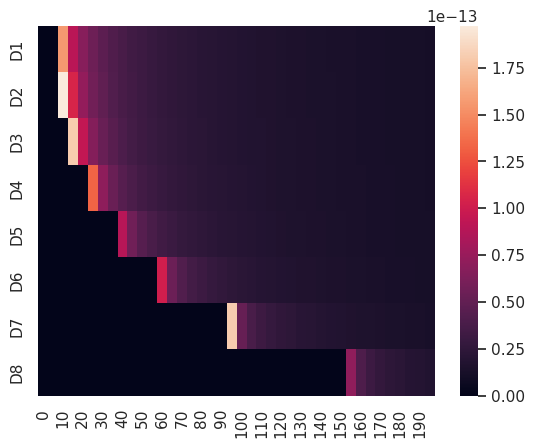

In [75]:
# set titme of sns
sns.heatmap(df, annot=False)
plt.show()